In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('stopwords')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packa

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##Reading data

In [3]:
data = pd.read_csv('/content/drive/My Drive/training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# a different sepeartor has been used 
data_text =pd.read_csv("/content/drive/My Drive/training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


#Preprocessing of Data

In [0]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 28.274878 seconds


In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
result[result.isnull().any(1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
#For a row which has an NaN text, we will it with Gene name + Variation name
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## Test, Train and Cross Validation Split

In [0]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

#splitting in a way such that the distributions of class labels is preserved 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#Featurization

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vec_train = CountVectorizer()

gene_train =  vec_train.fit_transform(train_df['Gene'])
gene_cv =  vec_train.transform(cv_df['Gene'])
gene_test =  vec_train.transform(test_df['Gene'])

print(" number of feature in gene" , len(vec_train.get_feature_names()))

 number of feature in gene 229


In [17]:
vec_train = CountVectorizer()

var_train =  vec_train.fit_transform(train_df['Variation'])
var_cv =  vec_train.transform(cv_df['Variation'])
var_test =  vec_train.transform(test_df['Variation'])
print(" number of feature in variation" , len(vec_train.get_feature_names()))

 number of feature in variation 1962


In [18]:
vec_train = CountVectorizer(min_df=3,ngram_range=(1,2))

txt_train =  vec_train.fit_transform(train_df['TEXT'])
txt_cv =  vec_train.transform(cv_df['TEXT'])
txt_test =  vec_train.transform(test_df['TEXT'])
print(" number of feature in text" , len(vec_train.get_feature_names()))

 number of feature in text 766149


In [0]:

train = hstack((gene_train,var_train))
train = hstack((train,txt_train)).tocsr()
train_y = np.array(list(train_df['Class']))

cv = hstack((gene_cv,var_cv))
cv = hstack((cv,txt_cv)).tocsr()
cv_y = np.array(list(cv_df['Class']))

test = hstack((gene_test,var_test))
test = hstack((test,txt_test)).tocsr()
test_y = np.array(list(test_df['Class']))



#ML models

In [0]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

##Logistic regression

for alpha = 0.01
Log Loss : 1.295466808871202
for alpha = 0.1
Log Loss : 1.2626208255671272
for alpha = 1
Log Loss : 1.1730683007123923
for alpha = 10
Log Loss : 1.1569562255618437
for alpha = 100
Log Loss : 1.2931930312038242


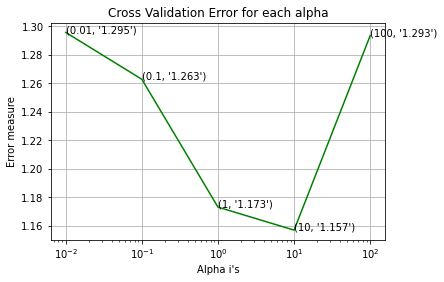

For values of best alpha =  10 The train log loss is: 0.8477441968856334
For values of best alpha =  10 The cross validation log loss is: 1.1569562255618437
For values of best alpha =  10 The test log loss is: 1.151428181473629


In [23]:




alpha = [10 ** x for x in range(-2,3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.xscale('log')
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train, train_y)

predict_y = sig_clf.predict_proba(train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.1569562255618437
Number of mis-classified points : 0.40037593984962405
-------------------- Confusion matrix --------------------


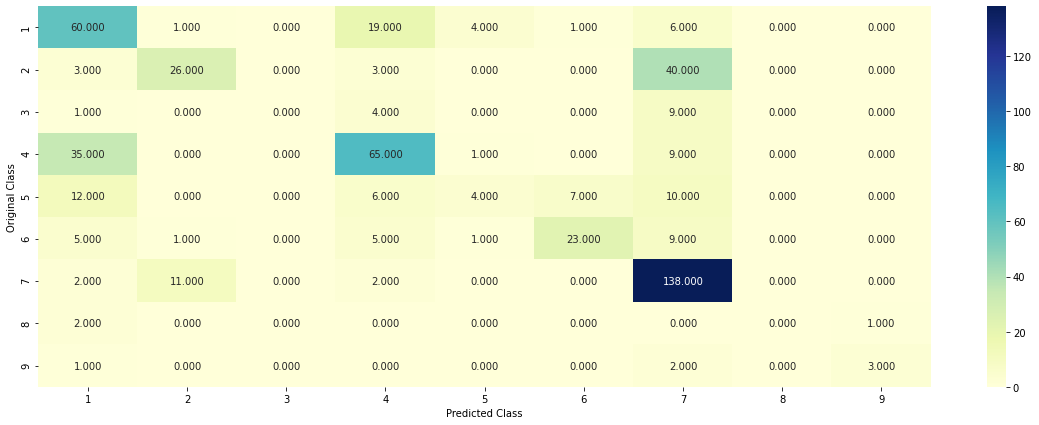

-------------------- Precision matrix (Columm Sum=1) --------------------


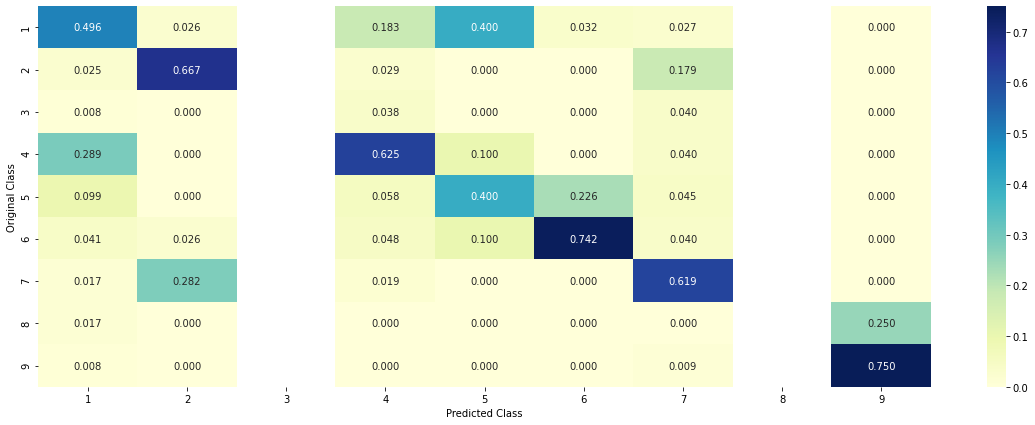

-------------------- Recall matrix (Row sum=1) --------------------


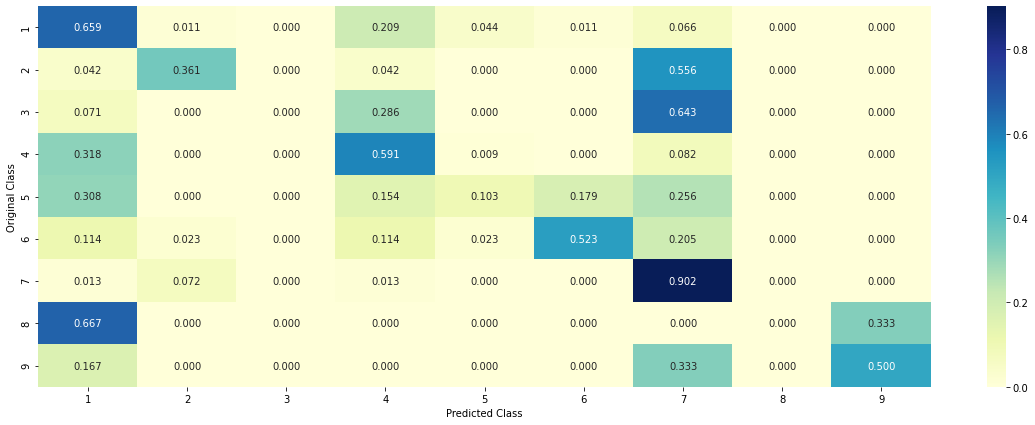

In [24]:

predict_and_plot_confusion_matrix(train, train_y, cv, cv_y, clf)

##Linear SVM

for alpha = 1e-06
Log Loss : 1.8308895093721702
for alpha = 1e-05
Log Loss : 1.8308895093721702
for alpha = 0.0001
Log Loss : 1.8308895093721702
for alpha = 0.001
Log Loss : 1.3042514867978845
for alpha = 0.01
Log Loss : 1.2627238246877894
for alpha = 0.1
Log Loss : 1.2660347829093004
for alpha = 1
Log Loss : 1.2158776053891358
for alpha = 10
Log Loss : 1.2044558275950388
for alpha = 100
Log Loss : 1.3066432115232236


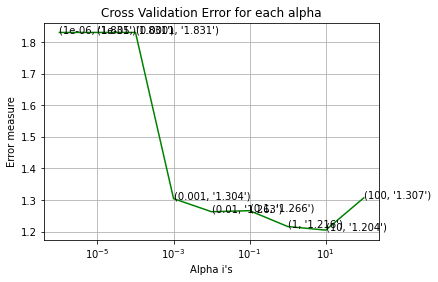

For values of best alpha =  10 The train log loss is: 0.836300379970516
For values of best alpha =  10 The cross validation log loss is: 1.2044558275950388
For values of best alpha =  10 The test log loss is: 1.2068302271636575


In [25]:




alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.xscale('log')
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train, train_y)

predict_y = sig_clf.predict_proba(train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
 

Log loss : 1.2044558275950388
Number of mis-classified points : 0.37969924812030076
-------------------- Confusion matrix --------------------


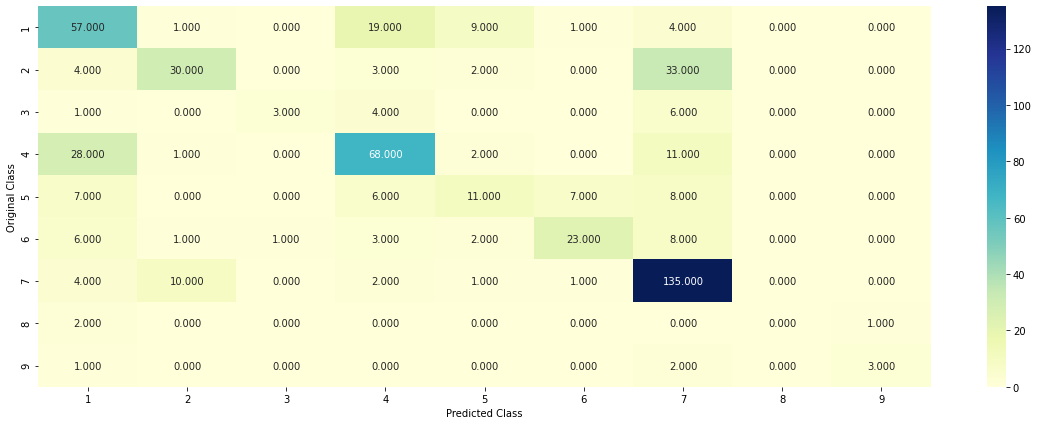

-------------------- Precision matrix (Columm Sum=1) --------------------


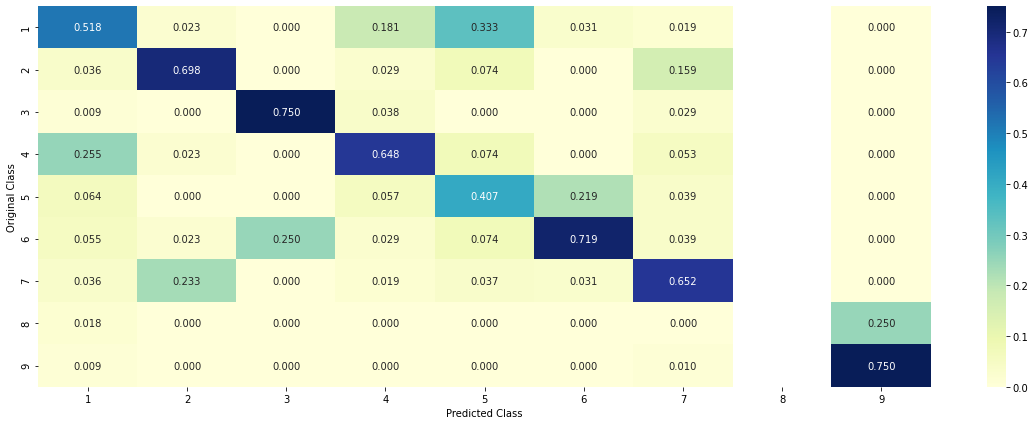

-------------------- Recall matrix (Row sum=1) --------------------


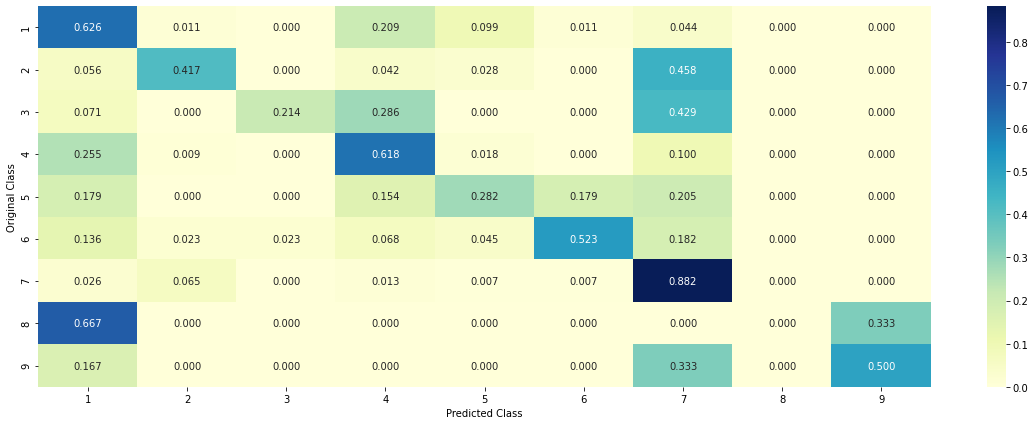

In [26]:

predict_and_plot_confusion_matrix(train, train_y, cv, cv_y, clf)